In [1]:
import pandas as pd
import numpy as np
import statistics

# this code calls tensorflow 1 compatibility
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import seaborn as sns
import DeepAE as DAE
import l21shrink as SHR  # also changing to l1 to access function
import xlrd
from robust_deep_autoencoders import RDAE
import numpy.linalg as nplin
import matplotlib.pyplot as plt


from scipy.cluster.hierarchy import weighted, fcluster, dendrogram, linkage
from scipy.spatial.distance import pdist
import seaborn as sns; sns.set_theme(color_codes=True)

Instructions for updating:
non-resource variables are not supported in the long term


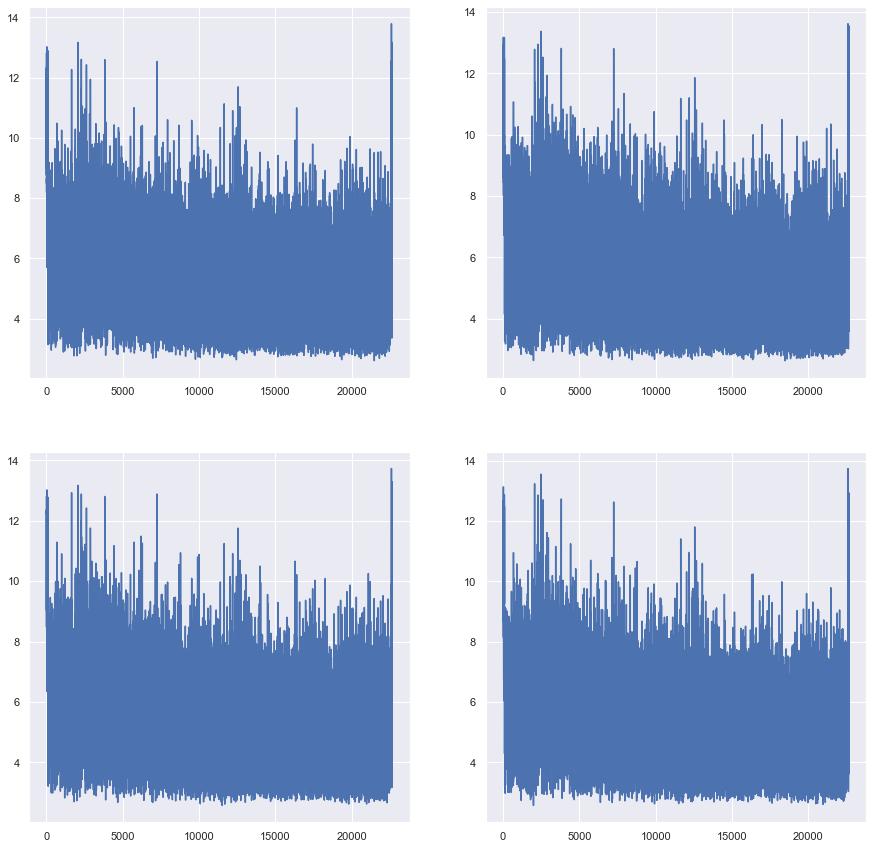

In [143]:
df = pd.read_csv("Leukemia_GSE22529_U133B.csv")
X = df.iloc[:,2:].to_numpy()


fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

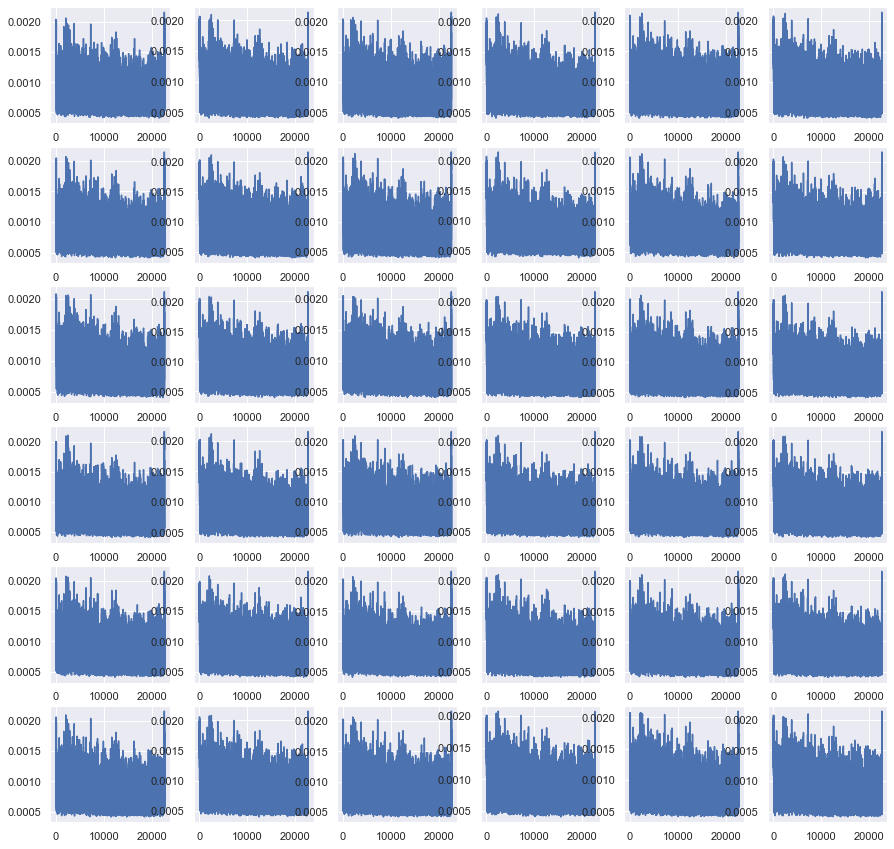

In [144]:
#Normalize
X = X/np.linalg.norm(X)
fig, axs = plt.subplots(6,6,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(X[count])
        count += 1

In [ ]:
X = np.matrix(X)
m,n = X.shape

In [145]:
def get_params(m, n, compression = 0.2):
    batch_size = round(m*0.5)
    inner_iter = round(m/batch_size)
    layers = [n, int((n*compression+n)/2), int(compression*n)]
    return batch_size, inner_iter, layers

batch_size, inner_iter, layers = get_params(m, n, compression = 0.02)
print(batch_size, inner_iter, layers)

26 2 [22645, 11548, 452]


In [146]:
with tf.Session() as sess:
    # layers = [n, int(n * 0.5)]
    rae = RDAE(sess=sess, lambda_=5000, layers_sizes=layers)
    # rae = RDAE(sess=sess, lambda_=2000, layers_sizes=[784, 400])

    L, S = rae.fit(X, sess=sess,
                   learning_rate=0.01,
                   batch_size=batch_size,
                   inner_iteration=inner_iter,
                   iteration=2, verbose=True)

    l21R = rae.getRecon(X, sess=sess)
    l21H = rae.transform(X, sess)

    print("cost errors, not used for now:", rae.errors)



L shape: (22645,)
X size is: 1177540 (in case it requires adjusting too)
shrink parameter: 0.0018937202953989791
X shape:  (52, 22645)
L shape:  (22645,)
S shape:  (22645,)
mu:  2640305.4411721206
XFnorm:  1.0
Out iteration:  0
    iteration :  0 , cost :  0.0001698456
Break Criterion 1: the L and S are close enough to X 0.9996988167568812
Break Criterion 2: there is no changes for L and S 7.082577874572226
Out iteration:  1
    iteration :  0 , cost :  0.0001697433
Break Criterion 1: the L and S are close enough to X 0.9996988167568812
Break Criterion 2: there is no changes for L and S 0.0
Out iteration:  2
    iteration :  0 , cost :  0.0001697433
Break Criterion 1: the L and S are close enough to X 0.9996988167568812
Break Criterion 2: there is no changes for L and S 0.0
Out iteration:  3
    iteration :  0 , cost :  0.0001697433
Break Criterion 1: the L and S are close enough to X 0.9996988167568812
Break Criterion 2: there is no changes for L and S 0.0
Out iteration:  4
    iterat

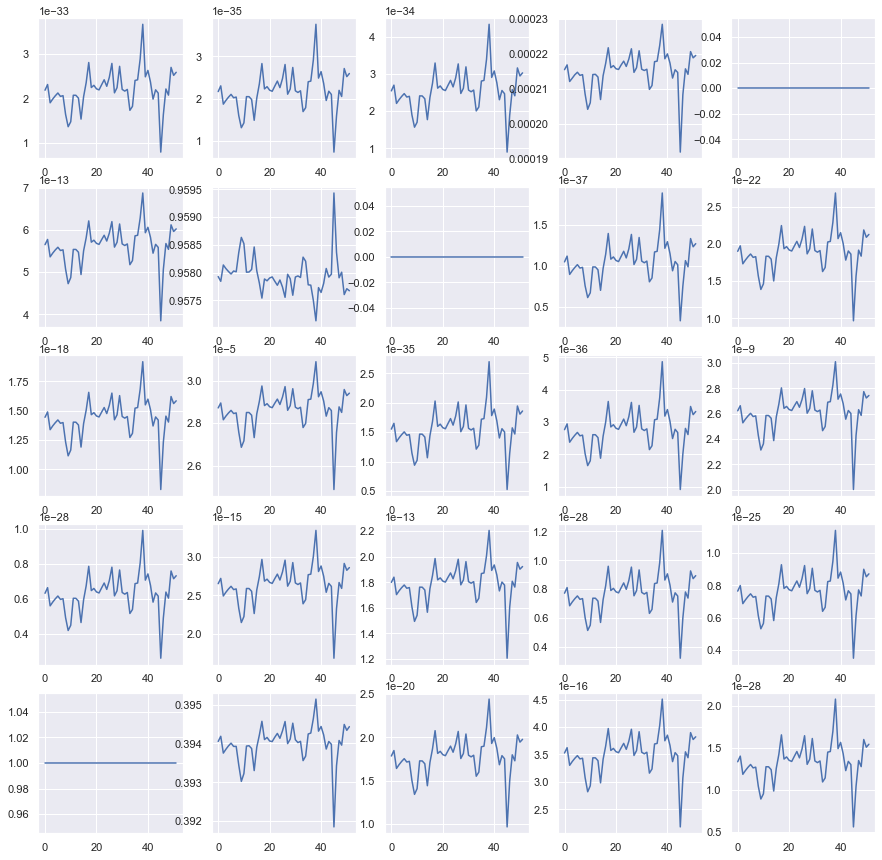

In [147]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(l21H[:, count])
        count += 1

l21R shape: (52, 22645)


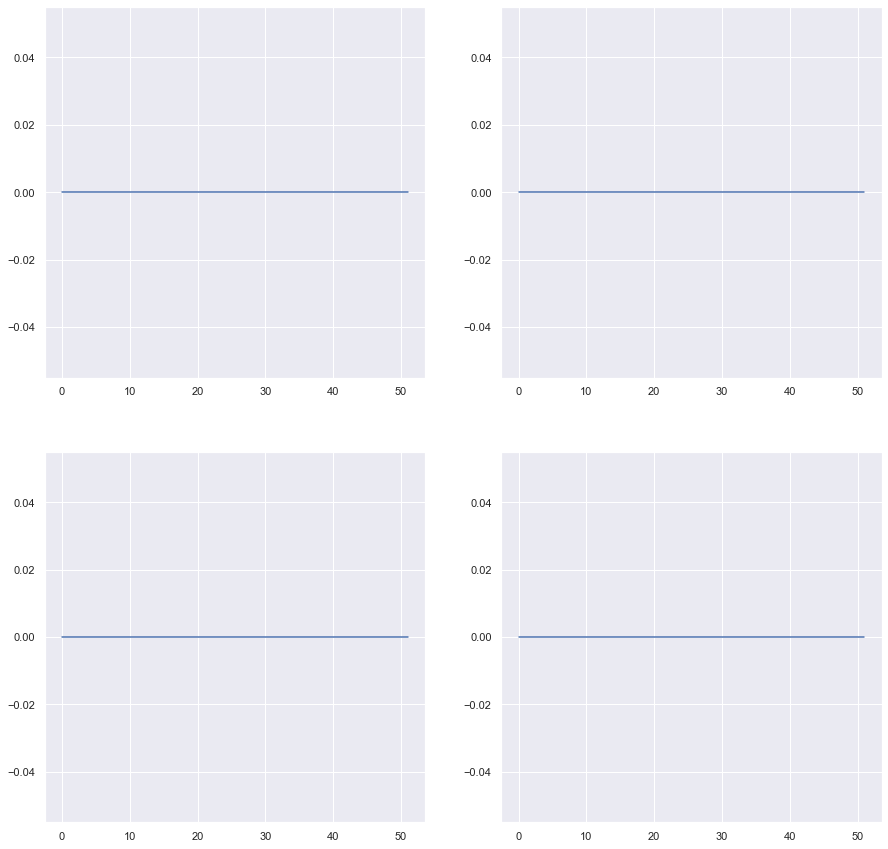

In [148]:
# Reconstruction
print("l21R shape:", l21R.shape)
fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(l21R[:,count])
        count += 1

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


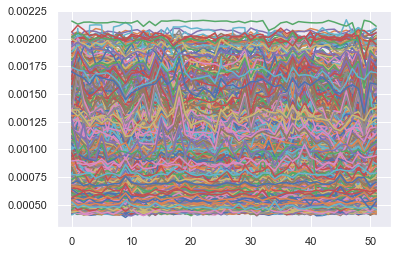

In [81]:
print(L)
plt.clf()
L = X - S
for i in range(S.shape[1]):
    # plt.plot(S[:,i], label = "S val")
    # plt.plot(L[:,i], label = "L val")
    plt.plot(X[:,i], label = "X val")

In [153]:
print(L.shape)
print(X.shape)
print(S.shape)

(52, 22645)
(52, 22645)
(52, 22645)


[[0.00142514 0.00140712 0.00178462 ... 0.00189372 0.00189372 0.00189372]
 [0.00147809 0.00151346 0.00186691 ... 0.00189372 0.00189372 0.00189372]
 [0.00141482 0.00156035 0.00181382 ... 0.00189372 0.00189372 0.00189372]
 ...
 [0.00145683 0.00149467 0.00179818 ... 0.00182816 0.00181853 0.00166579]
 [0.00147678 0.00150171 0.00187019 ... 0.00189372 0.00189372 0.0018713 ]
 [0.00149435 0.00160671 0.00189372 ... 0.00189372 0.00189372 0.00182658]]


<Figure size 432x288 with 0 Axes>

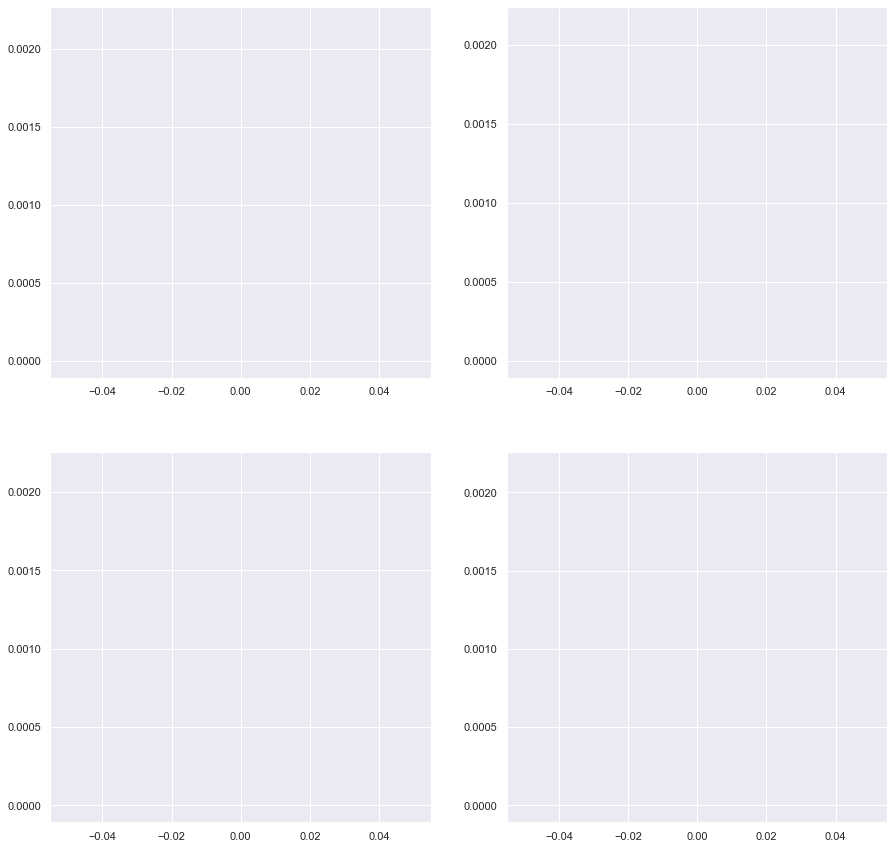

In [174]:
print(L)
plt.clf()
fig, axs = plt.subplots(2,2,figsize=(15,15))
count = 0
L = X - S
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].plot(S[count], label = "S val", color='green')
        axs[i,j].plot(L[count], label = "L val", color='blue')
        axs[i,j].plot(X[count], label = "X val", color='orange')
        count += 1

In [9]:
## Example
# X = [[0, 1, 2, 3],
#      [0, 2, 4, 2],
#      [1, 2, 9, 0],
#      [1, 2, 7, 8]]
#
#
# y = pdist(X)
#
# print(y)
# Z = weighted(y)
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
# plt.show()
#
# fcluster(Z, 0.9, criterion='distance')


/usr/local/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


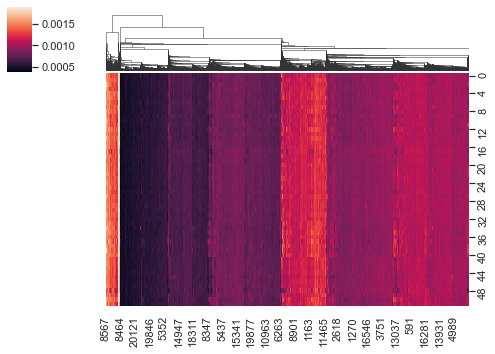

In [151]:
g = sns.clustermap(L,
                   figsize=(7, 5),
                   row_cluster=False)

print(g)

In [11]:
gene_community_map = pd.read_pickle('gene_community_map.pkl')

In [12]:
# Read in gene keys
gene_key = pd.read_csv('probeID_to_geneID_mapping.csv')
gene_key['Gene Symbol'] = gene_key['Gene Symbol'].map(lambda gene: gene.split('///')[0])
probeID_gene_dict = gene_key.set_index('Probe Set ID').T.to_dict('list')

In [13]:
probe_ids = df.columns[2:]
probe_id_clusters = []
for probe_id in probe_ids:
    if probe_id in probeID_gene_dict.keys() and probeID_gene_dict[probe_id][0] in gene_community_map.keys():
        gene = probeID_gene_dict[probe_id][0]
        probe_id_clusters.append(gene_community_map[gene])
    else:
        probe_id_clusters.append(-1)

probe_id_clusters = np.array(probe_id_clusters)

In [14]:
def weighted_pdist(i, j):
    if i == -1 or j == -1:
        return 1
    if i == j:
        return 0.9
    else:
        return 1.3

ppi_weights = pdist(np.expand_dims(probe_id_clusters, axis=1), weighted_pdist)

In [161]:
y = pdist(L.T, 'euclidean')
print(ppi_weights)


[1. 1. 1. ... 1. 1. 1.]


In [164]:
weighted_y = ppi_weights * y

In [165]:
Z = weighted(weighted_y)
print(Z)


[[3.20000000e+01 8.10000000e+01 0.00000000e+00 2.00000000e+00]
 [3.82300000e+03 2.26450000e+04 0.00000000e+00 3.00000000e+00]
 [2.50000000e+01 2.26460000e+04 2.16840434e-19 4.00000000e+00]
 ...
 [4.52830000e+04 4.52850000e+04 3.20433436e-03 1.12150000e+04]
 [4.52840000e+04 4.52860000e+04 3.62550677e-03 2.14120000e+04]
 [4.52820000e+04 4.52870000e+04 6.03562974e-03 2.26450000e+04]]


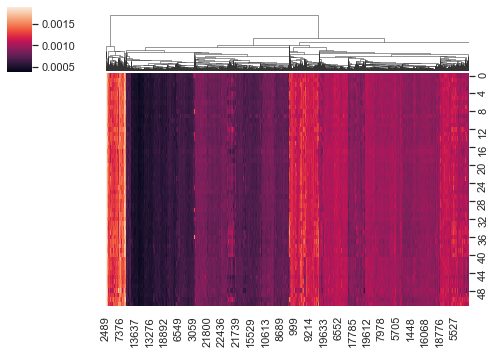

In [166]:
g = sns.clustermap(L,
                   figsize=(7, 5),
                   row_cluster=False,
                   col_linkage=Z)

print(g)

In [170]:
result = fcluster(Z, t=.002, criterion='distance')

22
22


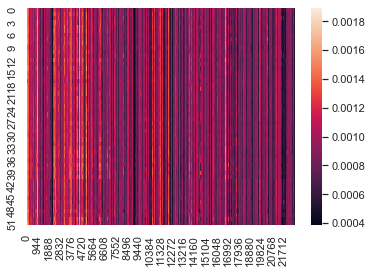

In [177]:
ax = sns.heatmap(L)